<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------------------------------------------------------
# 1. Conectar Google Drive para acceder a archivos externos
# ---------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
# Esto monta Google Drive dentro del entorno de Colab en la ruta /content/drive.
# Te permite leer y escribir archivos directamente en tu Drive, lo cual es útil
# para guardar modelos, cargar scripts personalizados o manejar datasets.


# ---------------------------------------------------------
# 2. Agregar la ruta del proyecto al PATH de Python
# ---------------------------------------------------------
import sys
sys.path.append("/content/drive/MyDrive/Proyecto_PTI")
# Con esta línea, agregas la carpeta de tu proyecto al sistema de rutas
# que Python utiliza para buscar módulos. Así puedes importar prepare_dataset.py
# aunque esté almacenado en Google Drive y no en el directorio actual.


# ---------------------------------------------------------
# 3. Importar las funciones necesarias del módulo prepare_dataset
# ---------------------------------------------------------
from prepare_dataset import prepare_dataloaders_kaggle, load_clean_split_kaggle
# Aquí importas las funciones clave del pipeline:
#
# - prepare_dataloaders_kaggle:
#       Carga el dataset, lo limpia, elimina duplicados, aplica data augmentation
#       (si se activa), realiza el split reproducible 70/15/15 y devuelve los
#       dataloaders listos para usar en entrenamiento.
#
# - load_clean_split_kaggle:
#       Hace la misma limpieza y split, pero devuelve únicamente las rutas y
#       etiquetas para fines de exploración de datos (EDA), sin crear dataloaders.


Mounted at /content/drive


In [ ]:
import kagglehub
# Importa la librería kagglehub, la cual permite descargar datasets directamente
# desde Kaggle sin necesidad de configurar manualmente un archivo kaggle.json.
# Es una herramienta moderna que simplifica mucho el manejo de datasets en Colab.


masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download(
    'masoudnickparvar/brain-tumor-mri-dataset'
)
# Descarga automáticamente el dataset "Brain Tumor MRI Dataset" del usuario
# masoudnickparvar en Kaggle.
#
# El dataset se descarga en un directorio temporal dentro del entorno de ejecución
# (por ejemplo: /root/.cache/kagglehub/... )
#
# La función devuelve la ruta local del dataset descargado, que guardamos en la
# variable masoudnickparvar_brain_tumor_mri_dataset_path, por si necesitas verificarla,
# inspeccionarla, o acceder a los archivos directamente.
#
# Importante:
#   - No es necesario autenticarse manualmente.
#   - KaggleHub se encarga de gestionar la conexión y descarga.
#   - Esto funciona muy bien en Colab y Kaggle Notebooks.


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.


In [ ]:
BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"
# Ruta donde Kaggle monta automáticamente el dataset descargado.

(X_train, y_train), (X_val, y_val), (X_test, y_test), classes = load_clean_split_kaggle(BASE_DIR)
# Carga las imágenes, elimina duplicados y genera el split 70/15/15 de forma reproducible.
# Devuelve rutas y etiquetas de train, val y test, junto con la lista de clases.


Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009



/tmp/ipython-input-2401905296.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis")


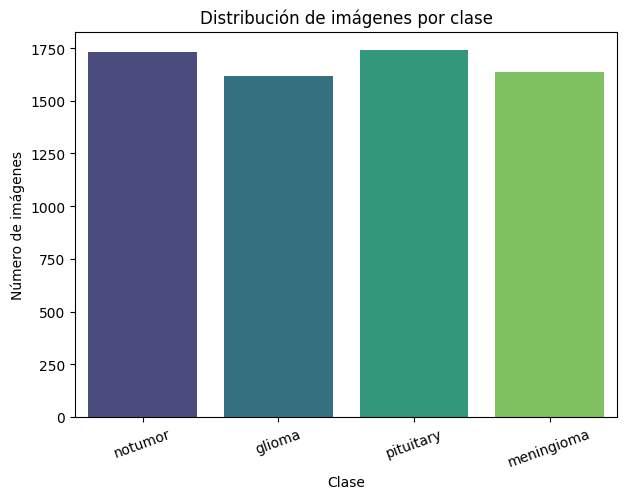

,path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
1,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
4,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
...,...,...
6721,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
6722,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
6723,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
6724,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(paths, labels):
    # Crea un DataFrame con rutas y etiquetas
    df = pd.DataFrame({"path": paths, "label": labels})

    # Gráfica de conteo por clase
    plt.figure(figsize=(7,5))
    sns.countplot(data=df, x="label", palette="viridis")
    plt.title("Distribución de imágenes por clase")
    plt.xlabel("Clase")
    plt.ylabel("Número de imágenes")
    plt.xticks(rotation=20)
    plt.show()

    return df


# Unir rutas y etiquetas en una sola lista para EDA
all_paths = X_train + X_val + X_test
all_labels = y_train + y_val + y_test

# DataFrame global con todas las imágenes
df = pd.DataFrame({
    "path": all_paths,
    "label": all_labels
})

# Gráfica de distribución de clases
plot_class_distribution(all_paths, all_labels)


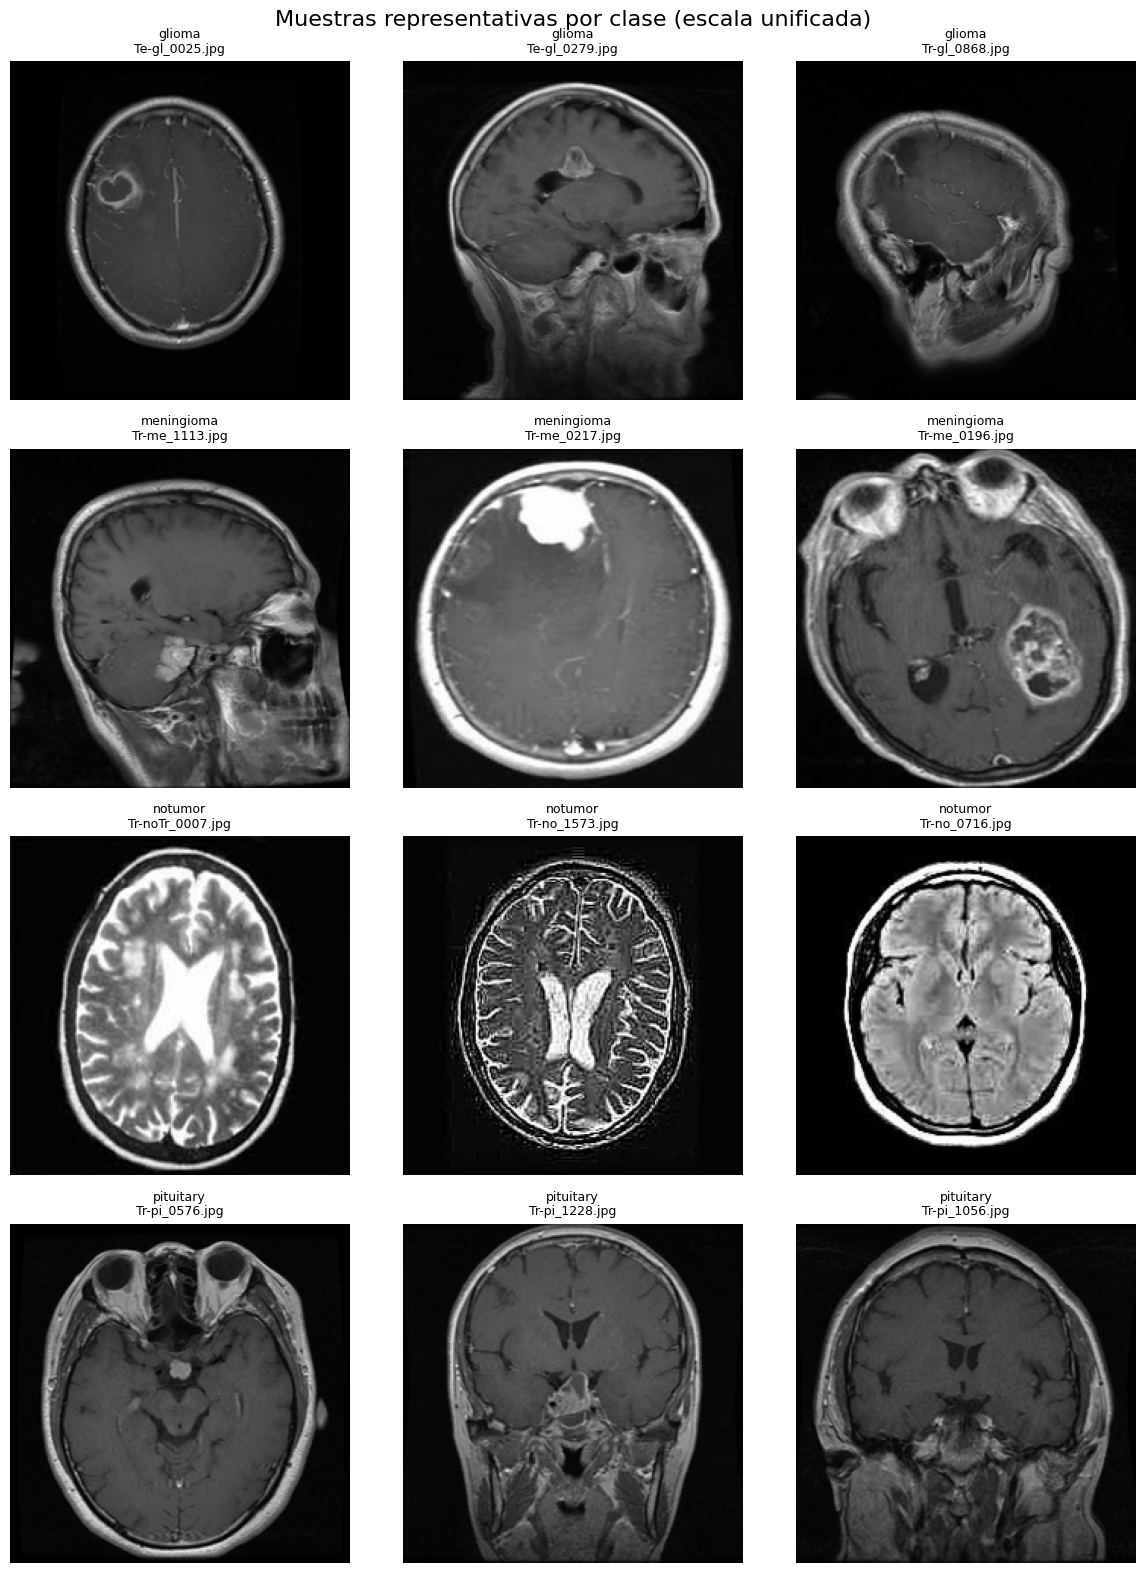

In [ ]:
import random
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_samples_per_class(df, n=4, img_size=(224, 224)):
    """
    Muestra n imágenes por clase, reescaladas a un mismo tamaño.
    También despliega la etiqueta y el nombre del archivo.
    """

    classes = sorted(df["label"].unique())  # Obtener clases ordenadas
    plt.figure(figsize=(4*n, 4*len(classes)))

    for i, cls in enumerate(classes):
        # Seleccionar n imágenes al azar para esta clase
        cls_imgs = df[df["label"] == cls]["path"].sample(n, random_state=23)

        for j, img_path in enumerate(cls_imgs):
            img = Image.open(img_path).convert("RGB")  # Cargar imagen
            img = img.resize(img_size)                 # Reescalar

            plt.subplot(len(classes), n, i*n + j + 1)
            plt.imshow(img)
            plt.axis("off")

            # Mostrar nombre del archivo y clase
            filename = os.path.basename(img_path)
            plt.title(f"{cls}\n{filename}", fontsize=9)

    plt.suptitle("Muestras representativas por clase (escala unificada)", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples_per_class(df, n=3)


In [ ]:
train_loader, val_loader, test_loader, classes = prepare_dataloaders_kaggle(BASE_DIR)
# Crea los DataLoaders de entrenamiento, validación y prueba usando el dataset en BASE_DIR.
# Incluye limpieza de duplicados, split 70/15/15 y transforms (con o sin augment según config).


Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

🔢 Mapeo clase → índice: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Usando DATA AUGMENTATION en entrenamiento


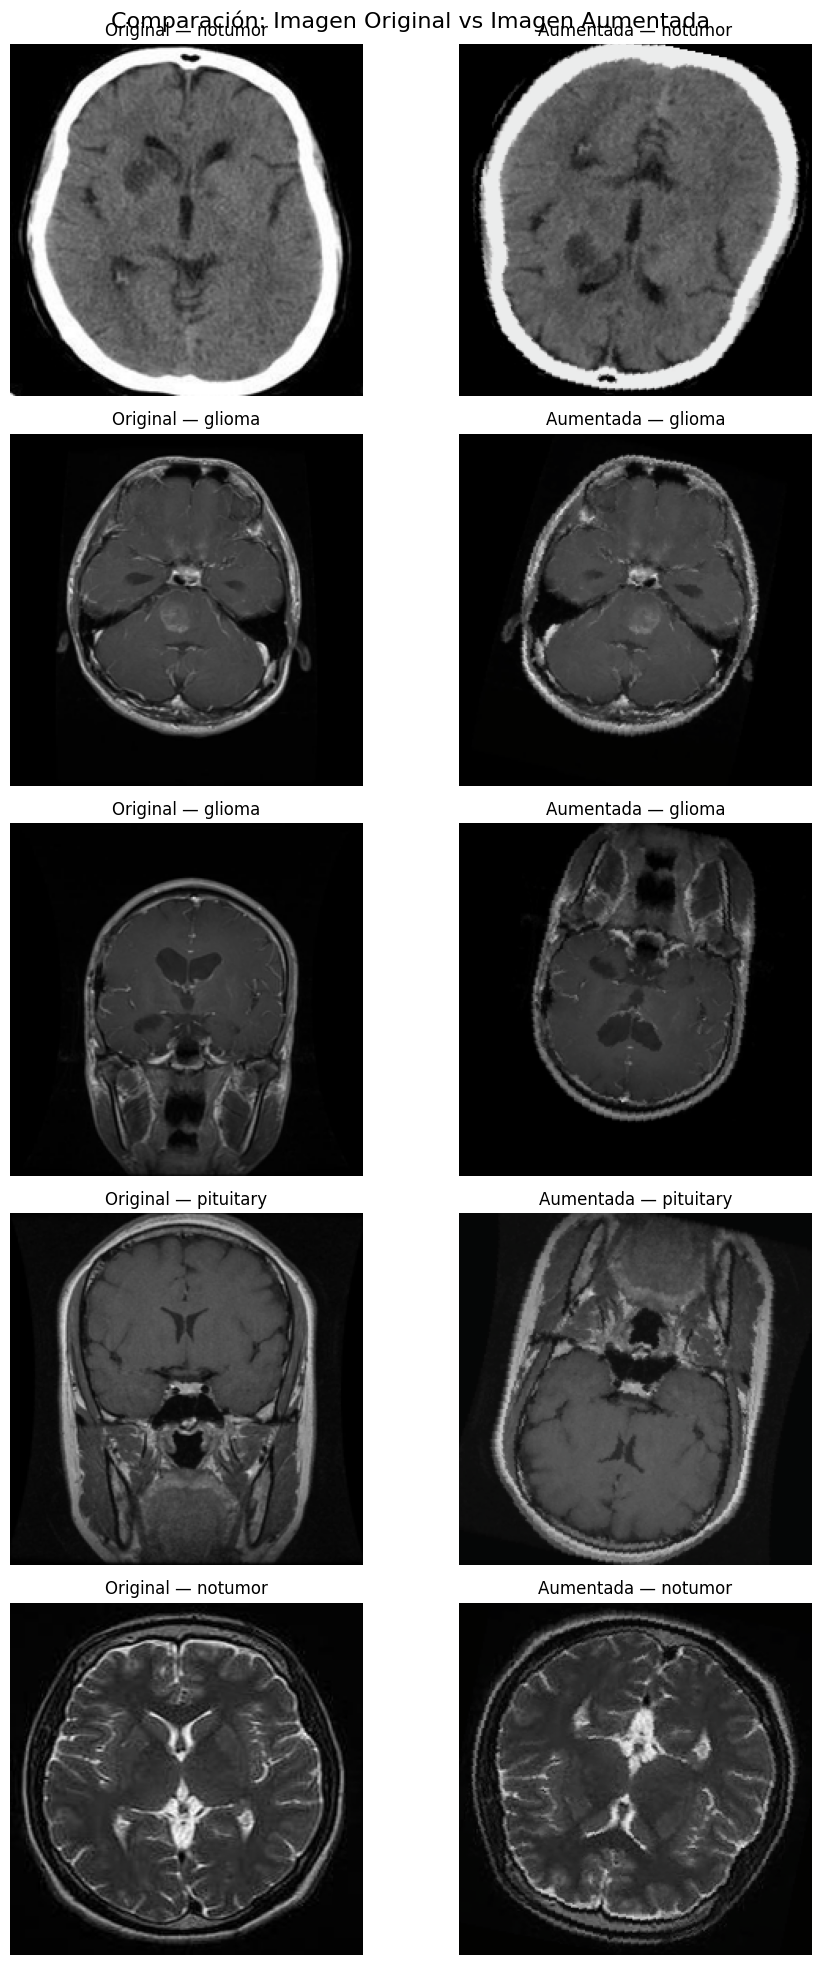

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_original_vs_augmented(train_loader, num_samples=5):
    """
    Muestra pares de imágenes: original vs aumentada,
    usando exactamente los transforms del conjunto de entrenamiento.
    """

    dataset = train_loader.dataset          # Accede al dataset interno del DataLoader
    transform = dataset.transform           # Transforms aplicados al entrenamiento

    # Seleccionar num_samples imágenes al azar del dataset
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(10, 4 * num_samples))

    for i, idx in enumerate(indices):
        # Cargar imagen original desde la ruta
        img_path = dataset.paths[idx]
        label = dataset.labels[idx]
        img_original = Image.open(img_path).convert("RGB")

        # Redimensionar para compararla visualmente
        img_original_resized = img_original.resize((224, 224))

        # Aplicar el transform de entrenamiento (incluye augmentation)
        img_aug = transform(img_original)

        # Desnormalizar imagen aumentada para mostrarla
        img_aug_np = img_aug.permute(1, 2, 0).numpy()
        img_aug_np = img_aug_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_aug_np = img_aug_np.clip(0, 1)

        # Imagen ORIGINAL
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_original_resized)
        plt.title(f"Original — {label}", fontsize=12)
        plt.axis("off")

        # Imagen AUMENTADA
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img_aug_np)
        plt.title(f"Aumentada — {label}", fontsize=12)
        plt.axis("off")

    plt.suptitle("Comparación: Imagen Original vs Imagen Aumentada", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizar 5 ejemplos
show_original_vs_augmented(train_loader, num_samples=5)


In [ ]:
from collections import Counter

def get_original_sizes(df):
    # Recolecta resoluciones originales de una muestra de imágenes
    sizes = []
    for p in df["path"].sample(300):  # tomar 300 imágenes para eficiencia
        img = Image.open(p)
        sizes.append(img.size)         # (ancho, alto)
    return Counter(sizes)              # cuenta tamaños repetidos

# Obtener distribución de tamaños en la muestra
sizes = get_original_sizes(df)
print("Tamaños de imágenes encontrados (muestra):")
sizes


Tamaños de imágenes encontrados (muestra):


Counter({(497, 398): 1,
         (630, 630): 3,
         (442, 442): 5,
         (228, 221): 1,
         (225, 225): 15,
         (512, 512): 206,
         (201, 250): 2,
         (192, 192): 5,
         (494, 600): 1,
         (173, 201): 2,
         (456, 501): 1,
         (367, 395): 1,
         (235, 233): 1,
         (207, 243): 1,
         (234, 225): 1,
         (205, 214): 1,
         (550, 664): 2,
         (200, 252): 2,
         (227, 262): 1,
         (300, 168): 3,
         (232, 217): 1,
         (359, 449): 2,
         (420, 264): 1,
         (442, 454): 1,
         (1365, 1365): 1,
         (441, 442): 2,
         (218, 231): 3,
         (236, 213): 1,
         (200, 235): 1,
         (206, 245): 1,
         (289, 354): 1,
         (215, 234): 1,
         (256, 256): 1,
         (236, 257): 1,
         (591, 650): 1,
         (468, 444): 1,
         (400, 442): 1,
         (150, 198): 1,
         (236, 236): 2,
         (312, 401): 1,
         (206, 244): 2,
         (3

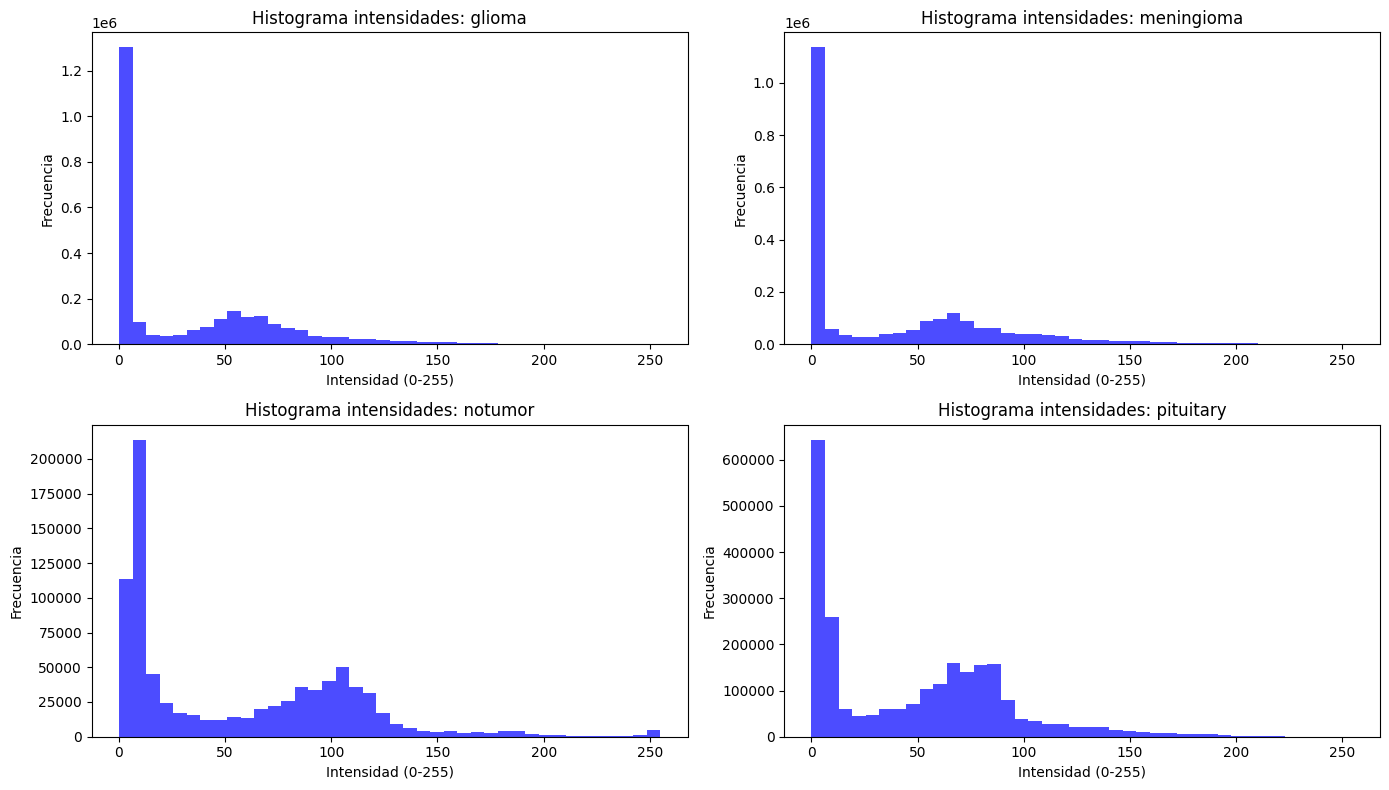

In [ ]:
import numpy as np

def plot_intensity_histograms(df, classes, samples=50):
    # Genera histogramas de intensidades para una muestra de imágenes por clase
    plt.figure(figsize=(14, 8))

    for i, cls in enumerate(classes):
        # Seleccionar aleatoriamente algunas imágenes de la clase
        cls_imgs = df[df["label"] == cls]["path"].sample(samples)
        intensities = []

        for p in cls_imgs:
            # Convertir imagen a escala de grises y a vector de intensidades
            img = np.array(Image.open(p).convert("L")).flatten()
            intensities.extend(img)

        # Graficar histograma por clase
        plt.subplot(2, 2, i+1)
        plt.hist(intensities, bins=40, alpha=0.7, color="blue")
        plt.title(f"Histograma intensidades: {cls}")
        plt.xlabel("Intensidad (0-255)")
        plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

# Ejecutar histograma usando 10 imágenes por clase
plot_intensity_histograms(df, classes, samples=10)
